# VideoPose Visualization

### Basic Imports

In [ ]:
import matplotlib
matplotlib.use('TKAgg')

import numpy as np
import matplotlib.pyplot as plt
from common.visualization import render_animation, render_opencv_animation, render_other_animation
from common.generators import ChunkedGenerator, UnchunkedGenerator
from common.camera import *
from common.model import *
from common.loss import *
from common.skeleton import Skeleton
import os
import json

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from mpl_toolkits.mplot3d import Axes3D
import subprocess as sp

In [ ]:
def read_json(filename, datapath="/datasets_local/DriveAndAct"):
    try:
        if filename.endswith("json"):
            data = json.load(open(os.path.join(datapath, filename), "r"))
        else:
            data = np.load(os.path.join(datapath, filename), allow_pickle=True)
        return data
    except TypeError:
        " You are trying to load a wrong type of file (Must be JSON or NPZ)"

In [ ]:
from matplotlib.pyplot import colorbar


def downsample_tensor(X, factor):
    length = X.shape[0]//factor * factor
    return np.mean(X[:length].reshape(-1, factor, *X.shape[1:]), axis=1)

def render_animation(keypoints_2d, poses_3d, images, skeleton, 
                     output='output.mp4',
                     datapath='/datasets_local/DriveAndAct', 
                     skip=0, fps=30, downsample=3, size=6, azim=180, bitrate=-1, limit=1000, elev=10):
    """_summary_

    Args:
        keypoints_2d (_type_): _description_
        poses_3d (_type_): _description_
        images (list): list of images names
        skeleton (Skeleton): skeleton attributes
        output (str, optional): _description_. Defaults to 'output.mp4'.
        datapath (str, optional): path to dataset folder. Defaults to '/datasets_local/DriveAndAct'.
        skip (int, optional): _description_. Defaults to 0.
        fps (int, optional): _description_. Defaults to 30.
        downsample (int, optional): decreasing factor for video speed   . Defaults to 3.
        size (int, optional): _description_. Defaults to 6.
        azim (int, optional): _description_. Defaults to 180.

    Raises:
        ValueError: _description_
    """
    plt.ioff()
    fig = plt.figure(figsize=(size*(1 + len(poses_3d)), size))
    ax_in = fig.add_subplot(1, 1 + len(poses_3d), 1)
    ax_in.get_xaxis().set_visible(False)
    ax_in.get_yaxis().set_visible(False)
    ax_in.set_axis_off()
    ax_in.set_title('Input')

    ax_3d = []
    lines_3d = []
    trajectories = []
    all_frames = []
    radius = 1.7
    # for index, (data) in enumerate(poses_3d[0]): #.items()
    ax = fig.add_subplot(1, 1 + len(poses_3d), 2, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlim3d([-radius/2, radius/2])
    ax.set_ylim3d([0, radius])
    ax.set_zlim3d([-radius/2, radius/2])
    try:
        ax.set_aspect('equal')
    except NotImplementedError:
        ax.set_aspect('auto')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.dist = 7.5
    ax.set_title("Ground truth") #, pad=35
    ax_3d.append(ax)
    lines_3d.append([])
    for index in range(min(limit, len(poses_3d[0]))):
        all_frames.append(plt.imread(os.path.join(datapath, images[index])))
        # trajectories.append(data[:, 0, [0, 1]])
    # poses_3d = list(poses_3d.values())
    poses_3d = list(poses_3d)
    print("frames length: ", np.array(all_frames).shape, len(all_frames), all_frames[0].shape)
  
    keypoints = keypoints_2d
    
    if downsample > 1:
        keypoints = downsample_tensor(keypoints_2d, downsample)
        all_frames = downsample_tensor(np.array(all_frames), downsample).astype('uint8')
        for idx in range(len(poses_3d[0])):
            poses_3d[0][idx] = downsample_tensor(poses_3d[0][idx], downsample)
            # trajectories[idx] = downsample_tensor(trajectories[idx], downsample)
        fps /= downsample
        
        
    initialized = False
    image = None
    lines = []
    points = None
    print()
    
    if limit < 1:
        limit = len(all_frames)
    else:
        limit = min(limit, len(all_frames))
        
    parents = skeleton.parents()
    def update_video(i):
        nonlocal initialized, image, lines, points

        """
        for n, ax in enumerate(ax_3d):
            ax.set_xlim3d([-radius/2 + trajectories[n][i, 0], radius/2 + trajectories[n][i, 0]])
            ax.set_ylim3d([-radius/2 + trajectories[n][i, 1], radius/2 + trajectories[n][i, 1]])
        """
        # Update 2D poses
        joints_right_2d = [2, 4, 6, 8, 10, 12, 14, 16]
        colors_2d = np.full(keypoints.shape[1], 'black')
        colors_2d[joints_right_2d] = 'red'
        if not initialized:
            image = ax_in.imshow(all_frames[i], aspect='equal')
            
            for j, j_parent in enumerate(parents):
                if j_parent == -1:
                    continue
                    
                if len(parents) == keypoints.shape[1]:
                    # Draw skeleton only if keypoints match (otherwise we don't have the parents definition)
                    if keypoints[i, j, 2] != 0 and keypoints[i, j_parent, 2] != 0 :
                        lines.append(ax_in.plot([keypoints[i, j, 0], keypoints[i, j_parent, 0]],
                                                [keypoints[i, j, 1], keypoints[i, j_parent, 1]], color='pink'))
                    else:
                        lines.append(ax_in.plot([0, 0],
                                                [0, 0], color='pink'))
                col = 'red' if j in skeleton.joints_right() else 'black'
                # for n, ax in enumerate(ax_3d):
                n = 0
                pos = poses_3d[n][i]
                if keypoints[i, j, 2] != 0 and keypoints[i, j_parent, 2] != 0 :
                    lines_3d[n].append(ax.plot([pos[j, 0], pos[j_parent, 0]],
                                               [-pos[j, 1], -pos[j_parent, 1]],
                                               [pos[j, 2], pos[j_parent, 2]], zdir='y', color=col))
                else:
                    lines_3d[n].append(ax.plot([0, 0], [0, 0], [0, 0], zdir='y', color="white"))

            if keypoints[i, 11, 2] != 0 and keypoints[i, 12, 2] != 0 :
                col = "blue"
            else:
                col = "white"
            extra_parent = 12
            lines.append(ax_in.plot([keypoints[i, 11, 0], keypoints[i, 12, 0]],
                                            [keypoints[i, 11, 1], keypoints[i, 12, 1]], color=col))
            lines_3d[n].append(ax.plot([pos[11, 0], pos[extra_parent, 0]],
                                        [-pos[11, 1], -pos[extra_parent, 1]],
                                        [pos[11, 2], pos[extra_parent, 2]], zdir='y', color=col))
            if keypoints[i, 5, 2] != 0 and keypoints[i, 6, 2] != 0 :
                col = "blue"
            else:
                col = "white"
            extra_parent = 6
            lines.append(ax_in.plot([keypoints[i, 5, 0], keypoints[i, 6, 0]],
                                            [keypoints[i, 5, 1], keypoints[i, 6, 1]], color=col))
            lines_3d[n].append(ax.plot([pos[5, 0], pos[extra_parent, 0]],
                                        [-pos[5, 1], -pos[extra_parent, 1]],
                                        [pos[5, 2], pos[extra_parent, 2]], zdir='y', color=col))
            
                
                
            
            points = ax_in.scatter(*keypoints[i, :, :2].T, 10, color=colors_2d, edgecolors='white', zorder=10) # replaced colors_2d

            initialized = True

        else:
            
            image.set_data(all_frames[i])

            for j, j_parent in enumerate(parents):
                if j_parent == -1:
                    continue
                
                if len(parents) == keypoints.shape[1]:
                    lines[j-1][0].set_color('pink')
                    if keypoints[i, j, 2] != 0 and keypoints[i, j_parent, 2] != 0 :
                        lines[j-1][0].set_data([keypoints[i, j, 0], keypoints[i, j_parent, 0]],
                                            [keypoints[i, j, 1], keypoints[i, j_parent, 1]])
                        
                    else:
                        lines[j-1][0].set_color('white')
                        lines[j-1][0].set_data([0, 0], [0, 0])
                        

                # for n, ax in enumerate(ax_3d):
                n = 0
                pos = poses_3d[0][i]
                if keypoints[i, j, 2] != 0 and keypoints[i, j_parent, 2] != 0 :
                    lines_3d[n][j-1][0].set_color(colors_2d[j-1])
                    lines_3d[n][j-1][0].set_xdata(np.array([pos[j, 0], pos[j_parent, 0]]))
                    lines_3d[n][j-1][0].set_ydata(-np.array([pos[j, 1], pos[j_parent, 1]]))
                    lines_3d[n][j-1][0].set_3d_properties(np.array([pos[j, 2], pos[j_parent, 2]]), zdir='y')
                else:
                    lines_3d[n][j-1][0].set_color("white")
                    lines_3d[n][j-1][0].set_xdata(np.array([0, 0]))
                    lines_3d[n][j-1][0].set_ydata(np.array([0, 0]))
                    lines_3d[n][j-1][0].set_3d_properties(np.array([0, 0]), zdir='y')
            
            # ADDED BONES
            if keypoints[i, 11, 2] != 0 and keypoints[i, 12, 2] != 0:
                lines[len(lines)-2][0].set_color('pink')
                extra_parent = 12
                lines[len(lines)-2][0].set_data([keypoints[i, 11, 0], keypoints[i, extra_parent, 0]],
                                            [keypoints[i, 11, 1], keypoints[i, extra_parent, 1]])
            if  keypoints[i, 5, 2] != 0 and keypoints[i, 6, 2] != 0:
                lines[len(lines)-1][0].set_color('pink')
                extra_parent = 6
                lines[len(lines)-1][0].set_data([keypoints[i, 5, 0], keypoints[i, extra_parent, 0]],
                                            [keypoints[i, 5, 1], keypoints[i, extra_parent, 1]])
                        
            if keypoints[i, 11, 2] != 0 and keypoints[i, 12, 2] != 0:
                extra_parent = 12
                lines_3d[n][len(lines_3d[n])-2][0].set_color("blue")
                lines_3d[n][len(lines_3d[n])-2][0].set_xdata(np.array([pos[11, 0], pos[extra_parent, 0]]))
                lines_3d[n][len(lines_3d[n])-2][0].set_ydata(-np.array([pos[11, 1], pos[extra_parent, 1]]))
                lines_3d[n][len(lines_3d[n])-2][0].set_3d_properties(np.array([pos[11, 2], pos[extra_parent, 2]]), zdir='y')
                        
            if  keypoints[i, 5, 2] != 0 and keypoints[i, 6, 2] != 0:
                extra_parent = 6
                lines_3d[n][len(lines_3d[n])-1][0].set_color("blue")
                lines_3d[n][len(lines_3d[n])-1][0].set_xdata(np.array([pos[5, 0], pos[extra_parent, 0]]))
                lines_3d[n][len(lines_3d[n])-1][0].set_ydata(-np.array([pos[5, 1], pos[extra_parent, 1]]))
                lines_3d[n][len(lines_3d[n])-1][0].set_3d_properties(np.array([pos[5, 2], pos[extra_parent, 2]]), zdir='y')
                      
            points.set_offsets(keypoints[i, :, :2])
            
        
        print('{}/{}      '.format(i, limit), end='\r')
        

    fig.tight_layout()
    print("Limit: ", limit)
    anim = FuncAnimation(fig, update_video, frames=np.arange(0, limit-1), interval=1000/fps, repeat=False)
    if output.endswith('.mp4'):
        from IPython.display import HTML
        HTML(anim.to_html5_video())  
        Writer = writers['ffmpeg']
        writer = Writer(fps=fps, metadata={}, bitrate=bitrate)
        plt.show()
        anim.save(output, writer=writer)
    elif output.endswith('.gif'):
        plt.show()
        anim.save(output, dpi=80, writer='imagemagick')
    else:
        raise ValueError('Unsupported output format (only .mp4 and .gif are supported)')
    plt.close()
    
    

### Visualize the groundtruth

In [ ]:
START_FRAME = 0
N_FRAMES = 200

In [ ]:
# Consider dataset
dataset = read_json("vp1_coco_format.json")
npz_2d_dataset = read_json("data_2d_dad_gt_train.npz")
npz_3d_dataset = read_json("data_3d_dad_train.npz")

In [ ]:
# images
images_list =[dataset["images"][i]["file_name"] for i in range(START_FRAME, START_FRAME + N_FRAMES)]
print(len(images_list))

# keypoints 2d
keypoints_2d = np.array([[dataset["annotations"][i]["keypoints"]] for i in range(START_FRAME, START_FRAME + N_FRAMES)])
keypoints_2d = np.reshape(keypoints_2d, (N_FRAMES, 17, 3))
print(keypoints_2d.shape)

# keypoints 3d
poses_3d = np.array([[dataset["annotations"][i]["keypoints_3d"]] for i in range(START_FRAME, START_FRAME + N_FRAMES)])
poses_3d = np.reshape(poses_3d, (1, N_FRAMES, 17, 3))

skeleton = Skeleton(parents=[-1, 0, 0, 1, 2, 0, 0, 5, 6, 7, 8, 5, 6, 11, 12, 13, 14], 
                    joints_left=[1, 3, 5, 7, 9, 11, 13, 15], 
                    joints_right=[2, 4, 6, 8, 10, 12, 14, 16])

In [ ]:
render_animation(keypoints_2d, poses_3d, images_list, skeleton, 
                     output='rendering/vp1_visu_test_azim_250.mp4',
                     datapath='/datasets_local/DriveAndAct', 
                     skip=0, fps=30, downsample=1, size=6, azim=250, bitrate=-1, limit=200)

In [ ]:

def render_image(keypoints, poses_3d, images_list, skeleton, 
                     output='output.png',
                     datapath='/datasets_local/DriveAndAct', 
                     skip=0, fps=30, downsample=3, size=6, azim=180, i=100, elev=15., title="Json"):
    
    plt.ioff()
    fig = plt.figure(figsize=(size*(1 + len(poses_3d)), size))
    ax_in = fig.add_subplot(1, 1 + len(poses_3d), 1)
    ax_in.get_xaxis().set_visible(False)
    ax_in.get_yaxis().set_visible(False)
    ax_in.set_axis_off()
    ax_in.set_title('Input')

    ax_3d = []
    lines_3d = []
    trajectories = []
    all_frames = images_list
    radius = 1.7
    # for index, (data) in enumerate(poses_3d[0]): #.items()
    ax = fig.add_subplot(1, 1 + len(poses_3d), 2, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    # ax.set_xlim3d([-radius/2, radius/2])
    ax.set_ylim3d([0, radius])
    ax.set_xlim3d([0, radius])
    ax.set_zlim3d([-radius/2, radius/2])
    try:
        ax.set_aspect('equal')
    except NotImplementedError:
        ax.set_aspect('auto')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.dist = 7.5
    ax.set_title("Ground truth") #, pad=35
    ax_3d.append(ax)
    lines_3d.append([])
   
        
    poses_3d = list(poses_3d)
    print("frames length: ", np.array(all_frames).shape, len(all_frames),)
        
        
    initialized = False
    image = None
    lines = []
    points = None
    

        
    parents = skeleton.parents()
   
        
    joints_right_2d = [2, 4, 6, 8, 10, 12, 14, 16]
    colors_2d = np.full(keypoints.shape[1], 'black')
    colors_2d[joints_right_2d] = 'red'

    image = ax_in.imshow(plt.imread(os.path.join(datapath, all_frames[i])), aspect='equal')
            
    for j, j_parent in enumerate(parents):
        if j_parent == -1:
            continue
                    
        if len(parents) == keypoints.shape[1]:
            # Draw skeleton only if keypoints match (otherwise we don't have the parents definition)
            if keypoints[i, j, 2] != 0 and keypoints[i, j_parent, 2] != 0 :
                ax_in.plot([keypoints[i, j, 0], keypoints[i, j_parent, 0]],
                                        [keypoints[i, j, 1], keypoints[i, j_parent, 1]], c='pink')
                if j == 11 and keypoints[i, 12, 2] != 0:
                    extra_parent = 12
                    ax_in.plot([keypoints[i, j, 0], keypoints[i, extra_parent, 0]],
                                            [keypoints[i, j, 1], keypoints[i, extra_parent, 1]],  c='deeppink')
                if j == 5 and keypoints[i, 6, 2] != 0:
                    extra_parent = 6
                    ax_in.plot([keypoints[i, j, 0], keypoints[i, extra_parent, 0]],
                                            [keypoints[i, j, 1], keypoints[i, extra_parent, 1]], c='deeppink')
          
            else:
                ax_in.plot([0, 0], [0, 0], color='blue')
        col = 'red' if j in skeleton.joints_right() else 'black'
        # for n, ax in enumerate(ax_3d):
        n = 0
        pos = poses_3d[n][i]
        if keypoints[i, j, 2] != 0 and keypoints[i, j_parent, 2] != 0 :
            ax.plot([-pos[j, 0], -pos[j_parent, 0]],[-pos[j, 1], -pos[j_parent, 1]],[-pos[j, 2], -pos[j_parent, 2]], zdir='y', c=col)
            if j==11 and keypoints[i, 12, 2] != 0:
                extra_parent = 12
                ax.plot([-pos[j, 0], -pos[extra_parent, 0]],[-pos[j, 1], -pos[extra_parent, 1]],[-pos[j, 2], -pos[extra_parent, 2]], zdir='y', c="deeppink")
            if j==5 and keypoints[i, 6, 2] != 0:
                extra_parent = 6
                ax.plot([-pos[j, 0], -pos[extra_parent, 0]],[-pos[j, 1], -pos[extra_parent, 1]],[-pos[j, 2], -pos[extra_parent, 2]], zdir='y', c="deeppink")
        else:
            ax.plot([0, 0], [0, 0], [0, 0], zdir='z', c="white")

        # points = ax_in.scatter(*keypoints[i, :2].T, c='red', s=10,  edgecolors='white', zorder=10) # replaced colors_2d

    # fig.tight_layout()
    plt.title(title)
    plt.savefig('rendering/{}_image_{}.png'.format(title, i))
    # plt.imshow(plt.imread("rendering/image_{}.png"), aspect="auto")
    fig.show()   

In [ ]:
npz_2d_dataset = read_json("data_2d_dad_gt_train.npz")
npz_3d_dataset = read_json("data_3d_dad_train.npz")

print()
npz_2d_dataset = npz_2d_dataset["positions_2d"].item()
npz_3d_dataset = npz_3d_dataset['positions_3d'].item()

print(type(npz_2d_dataset))
npz_2d_dataset = npz_2d_dataset["vp1"]['inner_mirror/vp1/run2_2018-05-29-14-33-44.ids_1']
print(npz_2d_dataset.shape)

npz_3d_dataset = npz_3d_dataset["vp1"]['inner_mirror/vp1/run2_2018-05-29-14-33-44.ids_1']

npz_2d_dataset = np.reshape(npz_2d_dataset, (len(npz_2d_dataset), 17, 3))
npz_3d_dataset = np.reshape(npz_3d_dataset, (1, len(npz_3d_dataset), 17, 3))
npz_2d_dataset = np.asarray(npz_2d_dataset, dtype=np.float64)
npz_3d_dataset = np.asarray(npz_3d_dataset, dtype=np.float64)


In [ ]:
render_animation(npz_2d_dataset, npz_3d_dataset, images_list, skeleton, 
                     output='rendering/NPZ_visu_test_azim_250.mp4',
                     datapath='/datasets_local/DriveAndAct', 
                     skip=0, fps=30, downsample=1, size=6, azim=250, bitrate=-1, limit=200)

In [ ]:
a = np.random.random((4, 17, 2))
print(a.shape)
b = np.ones((a.shape[0],a.shape[1],a.shape[2]+1)); 
b[:,:,:-1] = a
print(b.shape)
print("B shape")
print(b)

In [ ]:
from common.camera import *
X = npz_2d_dataset[..., :2].copy()
npz_2d_dataset_trsf =  normalize_screen_coordinates(X,  w=1280, h=1024)
npz_2d_dataset_trsf = image_coordinates(npz_2d_dataset_trsf, w=1280, h=1024)

In [ ]:
b = np.ones((npz_2d_dataset_trsf.shape[0],npz_2d_dataset_trsf.shape[1],npz_2d_dataset_trsf.shape[2]+1)); 
b[:,:,:-1] = npz_2d_dataset_trsf
print(b.shape)
b.dtype

In [ ]:
render_animation(npz_2d_dataset, npz_3d_dataset, images_list, skeleton, 
                     output='rendering/NPZ_visu_test_azim_correct_input.mp4',
                     datapath='/datasets_local/DriveAndAct', 
                     skip=0, fps=30, downsample=1, size=6, azim=250, bitrate=-1, limit=200)

In [ ]:
for i in range(len(b)):
    for j in range(17):
        if b[i, j, 0] == 0 and  b[i, j, 1] == 0:
            b[i, j, 2] = 0

In [ ]:
render_animation(b, npz_3d_dataset, images_list, skeleton, 
                     output='rendering/NPZ_visu_test_azim_unormalized_input.mp4',
                     datapath='/datasets_local/DriveAndAct', 
                     skip=0, fps=30, downsample=1, size=6, azim=250, bitrate=-1, limit=200)

# TESTING VISUALIZERS (OWN IMPLEMENTATION)

In [ ]:

import cv2
import numpy as np
from common.dad_dataset import DadHuman36MDataset


print('Loading 3D detections...')
dataset = DadHuman36MDataset(datapath = '/datasets_local/DriveAndAct/data_3d_dad_train.npz')


dad_metadata = {
    'layout_name': 'dad',
    'num_joints': 17,
    'keypoints_symmetry': [
        [1, 3, 5, 7, 9, 11, 13, 15],
        [2, 4, 6, 8, 10, 12, 14, 16],
    ]
}
print('Loading 2D detections...')
keypoints = np.load('/datasets_local/DriveAndAct/data_2d_dad_gt_train.npz', allow_pickle=True)
keypoints_metadata = dad_metadata
keypoints_symmetry = dad_metadata['keypoints_symmetry']
kps_left, kps_right = list(keypoints_symmetry[0]), list(keypoints_symmetry[1])
joints_left, joints_right = list(dataset.skeleton().joints_left()), list(dataset.skeleton().joints_right())
keypoints = keypoints['positions_2d'].item()

In [ ]:
import torch
from common.model import TemporalModel
from common.generators import *
from common.utils import deterministic_random

# Fetch
def fetch(subjects, action_filter=None, subset=1, parse_3d_poses=True):
    out_poses_3d = []
    out_poses_2d = []
    out_camera_params = []
    for subject in subjects:
        for i, action in enumerate(keypoints[subject].keys()):
            if action_filter is not None:
                found = False
                for a in action_filter:
                    if action.startswith(a):
                        found = True
                        break
                if not found:
                    continue
                
            poses_2d = np.array([keypoints[subject][action]])
            
            for i in range(len(poses_2d)): # Iterate across cameras
                out_poses_2d.append(poses_2d[i][198: 400])
                
               
            # Replaced by
            # out_poses_2d.append(poses_2d)
            
            if subject in dataset.cameras():
                cams = [dataset.cameras()[subject][i]]
                assert len(cams) == len(poses_2d), 'Camera count mismatch'
                for cam in cams:
                    if 'intrinsic' in cam:
                        out_camera_params.append(cam['intrinsic'])
                
            if parse_3d_poses and 'positions_3d' in dataset[subject][action]:
                poses_3d = dataset[subject][action]['positions_3d']
                assert len(poses_3d) == len(poses_2d), 'Camera count mismatch'
                for i in range(len(poses_3d)): # Iterate across cameras
                    pose_3d = poses_3d[i][198:400]
                    pose_3d = np.reshape(pose_3d, (len(pose_3d), 17, 3))
                    out_poses_3d.append(pose_3d)
    
    if len(out_camera_params) == 0:
        out_camera_params = None
    if len(out_poses_3d) == 0:
        out_poses_3d = None
    
    stride = 1
    if subset < 1:
        for i in range(len(out_poses_2d)):
            n_frames = int(round(len(out_poses_2d[i])//stride * subset)*stride)
            start = deterministic_random(0, len(out_poses_2d[i]) - n_frames + 1, str(len(out_poses_2d[i])))
            out_poses_2d[i] = out_poses_2d[i][start:start+n_frames:stride]
            if out_poses_3d is not None:
                out_poses_3d[i] = out_poses_3d[i][start:start+n_frames:stride]
    elif stride > 1:
        # Downsample as requested
        for i in range(len(out_poses_2d)):
            out_poses_2d[i] = out_poses_2d[i][::stride]
            if out_poses_3d is not None:
                out_poses_3d[i] = out_poses_3d[i][::stride]

    return out_camera_params, out_poses_3d, out_poses_2d

In [ ]:

subjects_test = ["vp1"]

print("Loading GT Poses ...")
cameras_valid, poses_valid, poses_valid_2d = fetch(subjects_test)

architecture = "3,3,3"
filter_widths = [int(x) for x in architecture.split(',')]

model_pos = TemporalModel(17, 2, dataset.skeleton().num_joints(),
                            filter_widths=filter_widths, causal=True, dropout=0.35, channels=1024,
                            dense=False)

checkpoint = torch.load('checkpoint/fully_supervised/fully_supervised_27/epoch_80.bin', map_location='cpu')
model_pos.load_state_dict(checkpoint['model_pos'])

print("Model loaded!")
receptive_field = model_pos.receptive_field()
print('INFO: Receptive field: {} frames'.format(receptive_field))
pad = (receptive_field - 1) // 2 # Padding on each side
print('INFO: Using causal convolutions')
causal_shift = pad

    
    
input_keypoints = keypoints["vp1"]["inner_mirror/vp1/run2_2018-05-29-14-33-44.ids_1"].copy()
gen = UnchunkedGenerator(None, None, [input_keypoints],
                        pad=pad, causal_shift=causal_shift, augment=True,
                        kps_left=kps_left, kps_right=kps_right, joints_left=joints_left, joints_right=joints_right)



In [ ]:
from common.loss import *
# Evaluate
def evaluate(test_generator, action=None, return_predictions=False, use_trajectory_model=False, nruns=10):
    epoch_loss_3d_pos = []
    epoch_loss_3d_pos_procrustes = []
    epoch_loss_3d_pos_scale = []
    epoch_loss_3d_vel = []
    with torch.no_grad():
            if not use_trajectory_model:
                model_pos.eval()
            else:
                model_traj.eval()
            N = 0
            for _, batch, batch_2d in test_generator.next_epoch():
                inputs_2d = torch.from_numpy(batch_2d.astype('float32'))
                if torch.cuda.is_available():
                    inputs_2d = inputs_2d.cuda()

                # Positional model
                if not use_trajectory_model:
                    predicted_3d_pos = model_pos(inputs_2d)
                else:
                    predicted_3d_pos = model_traj(inputs_2d)

                # Test-time augmentation (if enabled)
                if test_generator.augment_enabled():
                    # Undo flipping and take average with non-flipped version
                    predicted_3d_pos[1, :, :, 0] *= -1
                    if not use_trajectory_model:
                        predicted_3d_pos[1, :, joints_left + joints_right] = predicted_3d_pos[1, :, joints_right + joints_left]
                    predicted_3d_pos = torch.mean(predicted_3d_pos, dim=0, keepdim=True)
                    
                    print("\n Predicted Pos is then: \n", predicted_3d_pos.shape)
                if return_predictions:
                    return predicted_3d_pos.squeeze(0).cpu().numpy()
                    
                inputs_3d = torch.from_numpy(batch.astype('float32'))
                if torch.cuda.is_available():
                    inputs_3d = inputs_3d.cuda()
                inputs_3d[:, :, 0] = 0    
                if test_generator.augment_enabled():
                    inputs_3d = inputs_3d[:1]

                error = mpjpe(predicted_3d_pos, inputs_3d)
                epoch_loss_3d_pos_scale += inputs_3d.shape[0]*inputs_3d.shape[1] * n_mpjpe(predicted_3d_pos, inputs_3d).item()

                epoch_loss_3d_pos += inputs_3d.shape[0]*inputs_3d.shape[1] * error.item()
                N += inputs_3d.shape[0] * inputs_3d.shape[1]
                
                inputs = inputs_3d.cpu().numpy().reshape(-1, inputs_3d.shape[-2], inputs_3d.shape[-1])
                predicted_3d_pos = predicted_3d_pos.cpu().numpy().reshape(-1, inputs_3d.shape[-2], inputs_3d.shape[-1])

                epoch_loss_3d_pos_procrustes += inputs_3d.shape[0]*inputs_3d.shape[1] * p_mpjpe(predicted_3d_pos, inputs)

                # Compute velocity error
                epoch_loss_3d_vel += inputs_3d.shape[0]*inputs_3d.shape[1] * mean_velocity_error(predicted_3d_pos, inputs)
                
            if action is None:
                print('----------')
            else:
                print('----'+action+'----')
                e1 = (epoch_loss_3d_pos / N)*1000
                e2 = (epoch_loss_3d_pos_procrustes / N)*1000
                e3 = (epoch_loss_3d_pos_scale / N)*1000
                ev = (epoch_loss_3d_vel / N)*1000
                print('Test time augmentation:', test_generator.augment_enabled())
                print('Protocol #1 Error (MPJPE):', e1, 'mm')
                print('Protocol #2 Error (P-MPJPE):', e2, 'mm')
                print('Protocol #3 Error (N-MPJPE):', e3, 'mm')
                print('Velocity Error (MPJVE):', ev, 'mm')
                print('----------')

    return np.mean(e1), np.mean(e2), np.mean(e3), np.mean(ev)

In [ ]:
prediction = evaluate(gen, return_predictions=True)


# Ground Truth
ground_truth = dataset["vp1"]["inner_mirror/vp1/run2_2018-05-29-14-33-44.ids_1"]['positions_3d'].copy() # removed last key [args.viz_camera]
# Added
ground_truth =  np.reshape(ground_truth[0], (len(ground_truth[0]), 17, 3))

# Visualize Wholebody detections

In [ ]:
from common.skeleton import Skeleton
import json
import matplotlib.pyplot as plt

WHOLEBODY_SKELETON = Skeleton(parents=[-1, 0, 0, 1, 2, 0, 0, 5, 6, 7, 8, 5, 6, 11, 12, 13, 14, # body
                                       19, 17, 18,  21, 22, 20, # feet
                                       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 49, 
                                       41, 42, 43, 44, 62, # Sourcil droit
                                       66, 45, 46, 47, 48,  # sourcil gauche
                                       51, 52, 53, 0, # nez
                                       55, 56, 57, 58, 0, # bas du nez
                                       60, 61, 62, 63, 64, 59, # oeil droit
                                       66, 67, 68, 69, 70, 65, # oeil gauche
                                       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,  # bouche
                                       108, 91, 92, 93, 94, 93, 96, 97, 98, 96, 100, 101, 102, 100, 104, 105, 106, 104, 
                                       108, 109, 110, # main gauche
                                       129, 112, 113, 114, 115, 114, 117, 118, 119, 117, 121, 122, 123, 121, 125, 126, 127, 125, 129, 130, 131
                                       ], 
                    joints_left=[1, 3, 5, 7, 9, 11, 13, 15, 17, 18, 19, 32, 33, 34, 
                                 35, 36, 37, 38, 39, 45, 46, 47, 48, 49, 65, 66, 67, 68, 69, 70], 
                    joints_right=[2, 4, 6, 8, 10, 12, 14, 16, 20, 21, 22, 23, 24, 25, 
                                  26, 27, 28, 29, 30, 40, 41, 42, 43, 44, 59, 60, 61, 62, 63, 64])

im = plt.imread("/datasets_local/DriveAndAct/inner_mirror/vp1/run2_2018-05-29-14-33-44.ids_1_frame_283_resized.jpg")
data = json.load(open("/root/no_backup/DAA_PifPaf/wholebody/vp1/run2_2018-05-29-14-33-44.ids_1_frame_283_resized.jpg.predictions.json", "r"))[0]
print(data)
plt.imshow(im)
plt.scatter([data["keypoints"][3*i] for i in range(133)], [data["keypoints"][3*i+1] for i in range(133)], c='red')
for j, j_parent in enumerate(WHOLEBODY_SKELETON.parents()):
    if data['keypoints'][3*j+2] != 0 and data['keypoints'][3*j_parent+2] != 0:
        plt.plot([data['keypoints'][3*j], data['keypoints'][3*j_parent]], [data['keypoints'][3*j+1], data['keypoints'][3*j_parent+1]], c='blue')
plt.show()

# 4. Check whether the faces were rightly annotated

In [57]:
import json
import numpy as np
import matplotlib.pyplot as plt
from common.skeleton import Skeleton

data = json.load(open("/datasets_local/DriveAndAct/inter_202resized_vp1_pifpaf_face_and_body_coco_format.json", "r"))
ims = data["images"]
annots = data["annotations"]

wdata = json.load(open("/datasets_local/DriveAndAct/resized_vp1_pifpaf_wholebody_coco_format.json", "r"))
wims = wdata["images"]
wannots = wdata["annotations"]

print(len(wims), len(wannots), len(ims), len(annots))



28155 79453 1 1


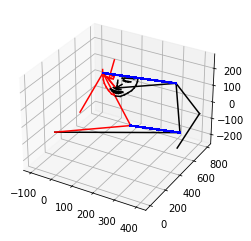

In [84]:

k2d= annots[0]["keypoints"]
k3d= annots[0]["keypoints_3d"]
k2d = np.array(k2d).reshape((1, 85, 3))
k3d = np.array(k3d).reshape((1, 85, 3))

k3d[0, 17:] *=-1
k3d[0, 17:, 2] *=1
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_3d_skeleton(0, k2d, k3d,  parents, FACE_AND_BODY_SKELETON, ax)

In [55]:
#for i in range(100, 130):
print(os.path.basename(ims[100]["file_name"]), os.path.basename(wims[128]["file_name"]))
print(ims[100])
print(annots[100]["image_id"])
print(wims[128])
print(np.array(annots[100]["keypoints_3d"]).shape)
print(wannots[128].keys())


IndexError: list index out of range

In [47]:
FACE_AND_BODY_SKELETON = Skeleton(parents=[-1, 0, 0, 1, 2, 0, 0, 5, 6, 7, 8, 5, 6, 11, 12, 13, 14, # body
                                       24-6, 25-6, 26-6, 27-6, 28-6, 29-6, 30-6, 31-6, 32-6, 33-6, 34-6, 35-6, 36-6, 37-6, 38-6, 39-6, 49-6, 
                                       41-6, 42-6, 43-6, 44-6, 62-6, # Sourcil droit
                                       66-6, 45-6, 46-6, 47-6, 48-6,  # sourcil gauche
                                       51-6, 52-6, 53-6, 0, # nez
                                       55-6, 56-6, 57-6, 58-6, 0, # bas du nez
                                       60-6, 61-6, 62-6, 63-6, 64-6, 59-6, # oeil droit
                                       66-6, 67-6, 68-6, 69-6, 70-6, 65-6, # oeil gauche
                                       72-6, 73-6, 74-6, 75-6, 76-6, 77-6, 78-6, 79-6, 80-6, 81-6, 82-6, 83-6, 84-6, 85-6, 86-6, 87-6, 88-6, 89-6, 90-6, -1 # bouche
                                       ], 
                    joints_left=[1, 3, 5, 7, 9, 11, 13, 15, 32-6, 33-6, 34-6, 
                                 35-6, 36-6, 37-6, 38-6, 39-6, 45-6, 46-6, 47-6, 48-6, 49-6, 65-6, 66-6, 67-6, 68-6, 69-6, 70-6], 
                    joints_right=[2, 4, 6, 8, 10, 12, 14, 16, 23-6, 24-6, 25-6, 
                                  26-6, 27-6, 28-6, 29-6, 30-6, 40-6, 41-6, 42-6, 43-6, 44-6, 59-6, 60-6, 61-6, 62-6, 63-6, 64-6])

#### We then define the plot functions

In [58]:
def plot_2d_skeleton(frame_id, keypoints, all_frames, parents, ax):
    im = plt.imread(os.path.join('/datasets_local/DriveAndAct', all_frames[frame_id]))
    image = ax.imshow(im, aspect='equal')
    h, w, _ = im.shape
    if keypoints[frame_id].shape[0] == 51:
        new_keypoints = np.zeros((frame_id+1, 17, 3))
        new_keypoints[frame_id] = np.reshape(keypoints[frame_id], (17, 3))
    if keypoints[frame_id].shape[0] == 399:
        new_keypoints = np.zeros((frame_id+1, 133, 3))
        new_keypoints[frame_id] = np.reshape(keypoints[frame_id], (133, 3))
    else:
        new_keypoints = keypoints
    for j, j_parent in enumerate(parents):
        if j_parent == -1:
            continue 
        if (new_keypoints[frame_id, j, 0] > 0 and new_keypoints[frame_id, j, 1] > 0) \
            and (new_keypoints[frame_id, j_parent, 0] > 0 and new_keypoints[frame_id, j_parent, 1] > 0) \
            and (new_keypoints[frame_id, j, 0] < h and new_keypoints[frame_id, j, 1] < w) \
            and (new_keypoints[frame_id, j_parent, 0] < h and new_keypoints[frame_id, j_parent, 1] < w):
            # Draw skeleton only if keypoints match (otherwise we don't have the parents definition)
            ax.plot([new_keypoints[frame_id, j, 0], new_keypoints[frame_id, j_parent, 0]],
                    [new_keypoints[frame_id, j, 1], new_keypoints[frame_id, j_parent, 1]], color='pink')
            
        if (new_keypoints[frame_id, 11, 0] != 0 and new_keypoints[frame_id, 12, 0] != 0) \
            and (new_keypoints[frame_id, 11, 1] != 0 and new_keypoints[frame_id, 12, 1] != 0) :   
            ax.plot([new_keypoints[frame_id, 11, 0], new_keypoints[frame_id, 12, 0]],
                    [new_keypoints[frame_id, 11, 1], new_keypoints[frame_id, 12, 1]], color="cornflowerblue")
        if (new_keypoints[frame_id, 5, 0] != 0 and new_keypoints[frame_id, 6, 0] != 0) \
            and (new_keypoints[frame_id, 5, 1] != 0 and new_keypoints[frame_id, 6, 1] != 0) :   
            ax.plot([new_keypoints[frame_id, 5, 0], new_keypoints[frame_id, 6, 0]],
                    [new_keypoints[frame_id, 5, 1], new_keypoints[frame_id, 6, 1]], color="cornflowerblue")
            
    # plt.savefig('/root/no_backup/tmp2d'+ str(frame_id) + '.jpg')

def plot_3d_skeleton(frame_id, keypoints, poses, parents, skeleton, ax): 
    pos = poses[frame_id]
    
    for j, j_parent in enumerate(parents): 
        col = 'red' if j in skeleton.joints_right() else 'black' 
        if j_parent == -1:
            continue 
        if (keypoints[frame_id, j, 0] > 0 and keypoints[frame_id, j, 1] > 0) \
        and (keypoints[frame_id, j_parent, 0] > 0 and keypoints[frame_id, j_parent, 1] > 0):
            ax.plot(pos[[j, j_parent], 0], -pos[[j, j_parent], 1],
                            pos[[j, j_parent], 2], c=col, zdir='y')  
        if (keypoints[frame_id, 11, 0] != 0 and keypoints[frame_id, 12, 0] != 0) \
            and (keypoints[frame_id, 11, 1] != 0 and keypoints[frame_id, 12, 1] != 0) :   
            ax.plot(pos[[11, 12], 0], -pos[[11, 12], 1],
                            pos[[11, 12], 2], c='blue', zdir='y')  
        if (keypoints[frame_id, 5, 0] != 0 and keypoints[frame_id, 6, 0] != 0) \
            and (keypoints[frame_id, 5, 1] != 0 and keypoints[frame_id, 6, 1] != 0) :   
            ax.plot(pos[[5, 6], 0], -pos[[5, 6], 1],
                            pos[[5, 6], 2], c='blue', zdir='y')        
        
             
    plt.savefig('/root/no_backup/tmp3d'+ str(frame_id) + '.jpg')     
    


[[ 1.46103047e+02 -1.60977878e+02  3.78101185e+02]
 [ 1.79287352e+02 -1.97912805e+02  3.66747975e+02]
 [ 1.13816727e+02 -2.02682361e+02  3.75682816e+02]
 [ 2.46603704e+02 -2.21767007e+02  4.08078196e+02]
 [ 1.02564827e+02 -2.73286134e+02  4.77627233e+02]
 [ 3.38487014e+02 -1.58040836e+02  6.34026140e+02]
 [ 4.09897126e-01 -1.18059039e+02  6.00567937e+02]
 [ 4.06234324e+02  5.63118383e+01  7.80684263e+02]
 [-9.97797213e+01  1.39561422e+02  5.55075437e+02]
 [ 3.50817010e+02  2.30520859e+02  6.38544023e+02]
 [-4.48310133e+01  2.48441041e+02  3.26154873e+02]
 [ 3.12165841e+02  2.14152135e+02  7.94687986e+02]
 [ 7.57617466e+01  2.47743420e+02  7.71264136e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

[[ 1.46103047e-01 -1.60977878e-01  3.78101185e-01]
 [ 1.79287352e-01 -1.97912805e-01  3.66747975e-01]
 [ 1.13816727e-01 -2.02682361

/tmp/ipykernel_35462/3645272064.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wkeypoints = np.array([np.array(anns["keypoints"]) for anns in wannots])


51


IndexError: list index out of range

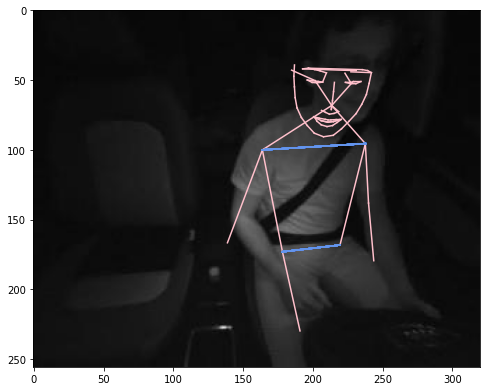

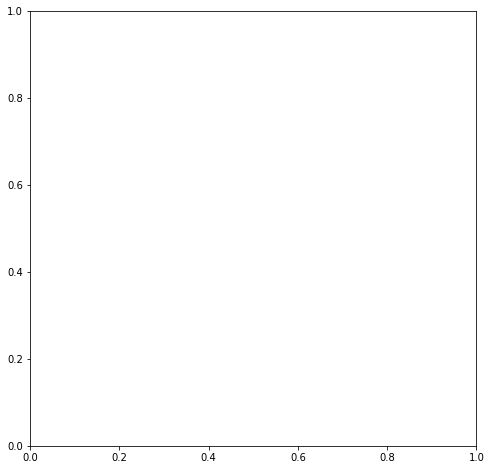

In [62]:
all_frames = [im["file_name"] for im in ims]
keypoints = np.array([np.array(anns["keypoints"]).reshape((85, 3)) for anns in annots])
keypoints3d = np.array([np.array(anns["keypoints_3d"]).reshape((85, 3)) for anns in annots])
print(keypoints3d[0, :17, :])
print()
keypoints3d[:, :17, :]*=0.001
print(keypoints3d[0, :17, :])
wall_frames = [im["file_name"] for im in wims]
wkeypoints = np.array([np.array(anns["keypoints"]) for anns in wannots])
wkeypoints3d = np.array([np.array(anns["keypoints_3d"]).reshape((len(np.array(anns["keypoints_3d"]))//3, 3)) for anns in wannots])
print(len(wkeypoints[0]))
FRAME = 5
PARENTS = FACE_AND_BODY_SKELETON.parents()

A = np.random.permutation(4627)

WHOLE_PARENTS=[-1, 0, 0, 1, 2, 0, 0, 5, 6, 7, 8, 5, 6, 11, 12, 13, 14, # body
                                        -1, -1, -1, -1, -1, -1,
                                       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 49, 
                                       41, 42, 43, 44, 62, # Sourcil droit
                                       66, 45-6, 46-6, 47-6, 48,  # sourcil gauche
                                       51, 52, 53, 0, # nez
                                       55, 56, 57, 58, 0, # bas du nez
                                       60, 61, 62, 63, 64, 59, # oeil droit
                                       66, 67, 68, 69, 70, 65, # oeil gauche
                                       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, -1 # bouche
                                       ]


FRAME = 0
START=198
fig, ax = plt.subplots(figsize=(8, 8))
plot_2d_skeleton(FRAME, wkeypoints[START:], all_frames, WHOLE_PARENTS, ax)
FRAME = 2030
START=0
fig, ax = plt.subplots(figsize=(8, 8))
plot_2d_skeleton(FRAME, wkeypoints[START:], all_frames, WHOLE_PARENTS, ax)


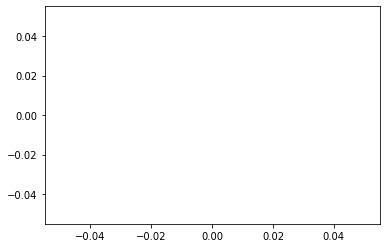

IndexError: list index out of range

In [63]:

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
line, = [[ax.plot([])]*(len(FACE_AND_BODY_SKELETON.parents())+1)]
initialized = False
parents=FACE_AND_BODY_SKELETON.parents()
line = []
START = 0

def animate(frame_id):
    frame_id = frame_id + START
    if frame_id == START:
        initialized = False
    else:
        initialized = True
    im = plt.imread(os.path.join('/datasets_local/DriveAndAct', all_frames[frame_id]))
    image = ax.imshow(im, aspect='equal')
    h, w, _ = im.shape
    
    if not initialized:
        for j, j_parent in enumerate(parents):
            if j_parent == -1:
                continue 
            if (keypoints[frame_id, j, 0] > 0 and keypoints[frame_id, j, 1] > 0) \
                and (keypoints[frame_id, j_parent, 0] > 0 and keypoints[frame_id, j_parent, 1] > 0):
            # and (keypoints[frame_id, j, 0] < h and keypoints[frame_id, j, 1] < w) \
            # and (keypoints[frame_id, j_parent, 0] < h and keypoints[frame_id, j_parent, 1] < w):
                # Draw skeleton only if keypoints match (otherwise we don't have the parents definition)
                line.append(ax.plot([keypoints[frame_id, j, 0], keypoints[frame_id, j_parent, 0]],
                        [keypoints[frame_id, j, 1], keypoints[frame_id, j_parent, 1]], c='pink'))
            else:
                line.append(ax.plot([0, 0], [0, 0], c='black'))
                
        if (keypoints[frame_id, 11, 0] != 0 and keypoints[frame_id, 12, 0] != 0) \
            and (keypoints[frame_id, 11, 1] != 0 and keypoints[frame_id, 12, 1] != 0) : 
            line.append(ax.plot([keypoints[frame_id, 11, 0], keypoints[frame_id, 12, 0]],
                    [keypoints[frame_id, 11, 1], keypoints[frame_id, 12, 1]], c='cornflowerblue'))
        else:
            line.append(ax.plot([0, 0], [0, 0], c='black'))
            
        if (keypoints[frame_id, 5, 0] != 0 and keypoints[frame_id, 6, 0] != 0) \
            and (keypoints[frame_id, 5, 1] != 0 and keypoints[frame_id, 6, 1] != 0) :   
            line.append(ax.plot([keypoints[frame_id, 5, 0], keypoints[frame_id, 6, 0]],
                    [keypoints[frame_id, 5, 1], keypoints[frame_id, 6, 1]], c='cornflowerblue'))
        else:
            line.append(ax.plot([0, 0], [0, 0], c='black'))
        initialized = True
    else:
        if (keypoints[frame_id, 5, 0] != 0 and keypoints[frame_id, 6, 0] != 0) \
            and (keypoints[frame_id, 5, 1] != 0 and keypoints[frame_id, 6, 1] != 0) :   
            line[len(line)-1][0].set_color('cornflowerblue')  
            line[len(line)-1][0].set_data([keypoints[frame_id, 5, 0], keypoints[frame_id, 6, 0]],
                    [keypoints[frame_id, 5, 1], keypoints[frame_id, 6, 1]])
        else:
            line[len(line)-1][0].set_color('cyan')
            line[len(line)-1][0].set_data([0, 0],
                        [0, 0])
        for j, j_parent in enumerate(parents):
            if j_parent == -1:
                continue 
            if (keypoints[frame_id, j, 0] > 0 and keypoints[frame_id, j, 1] > 0) \
                and (keypoints[frame_id, j_parent, 0] > 0 and keypoints[frame_id, j_parent, 1] > 0):
            # and (keypoints[frame_id, j, 0] < h and keypoints[frame_id, j, 1] < w) \
            # and (keypoints[frame_id, j_parent, 0] < h and keypoints[frame_id, j_parent, 1] < w):
                # Draw skeleton only if keypoints match (otherwise we don't have the parents definition)
                line[j-1][0].set_color('pink')
                line[j-1][0].set_data([keypoints[frame_id, j, 0], keypoints[frame_id, j_parent, 0]],
                        [keypoints[frame_id, j, 1], keypoints[frame_id, j_parent, 1]])
            else:
                line[j-1][0].set_color('cyan')
                line[j-1][0].set_data([0, 0],
                        [0, 0])
                
        if (keypoints[frame_id, 11, 0] != 0 and keypoints[frame_id, 12, 0] != 0) \
            and (keypoints[frame_id, 11, 1] != 0 and keypoints[frame_id, 12, 1] != 0) : 
            line[len(line)-2][0].set_color('cornflowerblue')  
            line[len(line)-2][0].set_data([keypoints[frame_id, 11, 0], keypoints[frame_id, 12, 0]],
                    [keypoints[frame_id, 11, 1], keypoints[frame_id, 12, 1]])
        else:
            line[len(line)-2][0].set_color('cyan')
            line[len(line)-2][0].set_data([0, 0],
                        [0, 0])
            
        
    return line

anim = FuncAnimation(fig, animate, frames=20, interval=50)
plt.show()
anim.save("anima.mp4")

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
radius=1.7
ax.view_init(azim=-85, elev=8)
ax.set_xlim3d([-radius/2, radius/2])
ax.set_ylim3d([-radius/4, 3*radius/4])
# ax.set_ylim3d([radius/2, radius/2*3])
ax.set_zlim3d([-radius/2, radius/2]) # exchange limits for y and z
try:
    ax.set_aspect('equal')
except NotImplementedError:
    ax.set_aspect('auto')

ax.dist = 7.5

line = []

def animate3d(frame_id, parents=FACE_AND_BODY_SKELETON.parents()):
    frame_id = frame_id + START
    if frame_id == START:
        initialized = False
    else:
        initialized = True
    
    if not initialized:
        for j, j_parent in enumerate(parents):
            if j_parent == -1:
                continue 
            if (keypoints[frame_id, j, 0] > 0 and keypoints[frame_id, j, 1] > 0) \
                and (keypoints[frame_id, j_parent, 0] > 0 and keypoints[frame_id, j_parent, 1] > 0):
            # and (keypoints[frame_id, j, 0] < h and keypoints[frame_id, j, 1] < w) \
            # and (keypoints[frame_id, j_parent, 0] < h and keypoints[frame_id, j_parent, 1] < w):
                # Draw skeleton only if keypoints match (otherwise we don't have the parents definition)
                line.append(ax.plot([keypoints3d[frame_id, j, 0], keypoints3d[frame_id, j_parent, 0]], 
                                    [-keypoints3d[frame_id, j, 1], -keypoints3d[frame_id, j_parent, 1]],
                                    [keypoints3d[frame_id, j, 2], keypoints3d[frame_id, j_parent, 2]], zdir='y', c='pink'))
            else:
                line.append(ax.plot([0, 0], [0, 0], [0, 0], zdir='y', c='white'))
                
        if (keypoints[frame_id, 11, 0] != 0 and keypoints[frame_id, 12, 0] != 0) \
            and (keypoints[frame_id, 11, 1] != 0 and keypoints[frame_id, 12, 1] != 0) : 
            line.append(ax.plot([keypoints3d[frame_id, 11, 0], keypoints3d[frame_id, 12, 0]],
                    [-keypoints3d[frame_id, 11, 1], -keypoints3d[frame_id, 12, 1]], 
                    [keypoints3d[frame_id, 11, 2], keypoints3d[frame_id, 12, 2]], zdir='y', c='cornflowerblue'))
        else:
            line.append(ax.plot([0, 0], [0, 0], [0, 0], zdir='y', c='white'))
            
        if (keypoints[frame_id, 5, 0] != 0 and keypoints[frame_id, 6, 0] != 0) \
            and (keypoints[frame_id, 5, 1] != 0 and keypoints[frame_id, 6, 1] != 0) :   
            line.append(ax.plot([keypoints3d[frame_id, 5, 0], keypoints3d[frame_id, 6, 0]],
                                [-keypoints3d[frame_id, 5, 1], -keypoints3d[frame_id, 6, 1]],
                    [keypoints3d[frame_id, 5, 2], keypoints3d[frame_id, 6, 2]], zdir='y', c='cornflowerblue'))
        else:
            line.append(ax.plot([0, 0], [0, 0], [0, 0], zdir='y', c='white'))
        initialized = True
    else:
        if (keypoints[frame_id, 5, 0] != 0 and keypoints[frame_id, 6, 0] != 0) \
            and (keypoints[frame_id, 5, 1] != 0 and keypoints[frame_id, 6, 1] != 0) :   
            line[len(line)-1][0].set_color('cornflowerblue')  
            line[len(line)-1][0].set_xdata([keypoints3d[frame_id, 5, 0], keypoints3d[frame_id, 6, 0]])
            line[len(line)-1][0].set_ydata([-keypoints3d[frame_id, 5, 1], -keypoints3d[frame_id, 6, 1]])
            line[len(line)-1][0].set_3d_properties([keypoints3d[frame_id, 5, 2], keypoints3d[frame_id, 6, 2]], zdir='y')
            
        else:
            line[len(line)-1][0].set_color('cyan')
            line[len(line)-1][0].set_xdata([0, 0])
            line[len(line)-1][0].set_ydata([0, 0])
            line[len(line)-1][0].set_3d_properties([0, 0], zdir='y')
        for j, j_parent in enumerate(parents):
            if j_parent == -1:
                continue 
            if (keypoints[frame_id, j, 0] > 0 and keypoints[frame_id, j, 1] > 0) \
                and (keypoints[frame_id, j_parent, 0] > 0 and keypoints[frame_id, j_parent, 1] > 0):
            # and (keypoints[frame_id, j, 0] < h and keypoints[frame_id, j, 1] < w) \
            # and (keypoints[frame_id, j_parent, 0] < h and keypoints[frame_id, j_parent, 1] < w):
                # Draw skeleton only if keypoints match (otherwise we don't have the parents definition)
                line[j-1][0].set_color('navy')
                line[j-1][0].set_xdata([keypoints3d[frame_id, j, 0], keypoints3d[frame_id, j_parent, 0]])
                line[j-1][0].set_ydata([-keypoints3d[frame_id, j, 1], -keypoints3d[frame_id, j_parent, 1]])
                line[j-1][0].set_3d_properties([keypoints3d[frame_id, j, 2], keypoints3d[frame_id, j_parent, 2]], zdir='y')
                        
            else:
                line[j-1][0].set_color('cyan')
                line[j-1][0].set_xdata([0, 0])
                line[j-1][0].set_ydata([0, 0])
                line[j-1][0].set_3d_properties([0, 0], zdir='y')
                
        if (keypoints[frame_id, 11, 0] != 0 and keypoints[frame_id, 12, 0] != 0) \
            and (keypoints[frame_id, 11, 1] != 0 and keypoints[frame_id, 12, 1] != 0) : 
            line[len(line)-2][0].set_color('cornflowerblue')  
            line[len(line)-2][0].set_xdata([keypoints3d[frame_id, 11, 0], keypoints3d[frame_id, 12, 0]])
            line[len(line)-2][0].set_ydata([-keypoints3d[frame_id, 11, 1], -keypoints3d[frame_id, 12, 1]])
            line[len(line)-2][0].set_3d_properties([keypoints3d[frame_id, 11, 2], keypoints3d[frame_id, 12, 2]], zdir='y')
        else:
            line[len(line)-2][0].set_color('cyan')
            line[len(line)-2][0].set_xdata([0, 0])
            line[len(line)-2][0].set_ydata([0, 0])
            line[len(line)-2][0].set_3d_properties([0, 0], zdir='y')
            
        
    return line

anim = FuncAnimation(fig, animate3d, frames=200, interval=50)
plt.show()
anim.save("animation3d.mp4")

1
[160.09674662 100.13492801   1.        ]
[nan nan nan]
35.08868408203125



/tmp/ipykernel_35462/3825790975.py:23: RuntimeWarning: invalid value encountered in divide
  print(np.dot(Kint, wkeypoints3d[frame_id][6]) / wkeypoints3d[frame_id][6][2])


IndexError: list index out of range

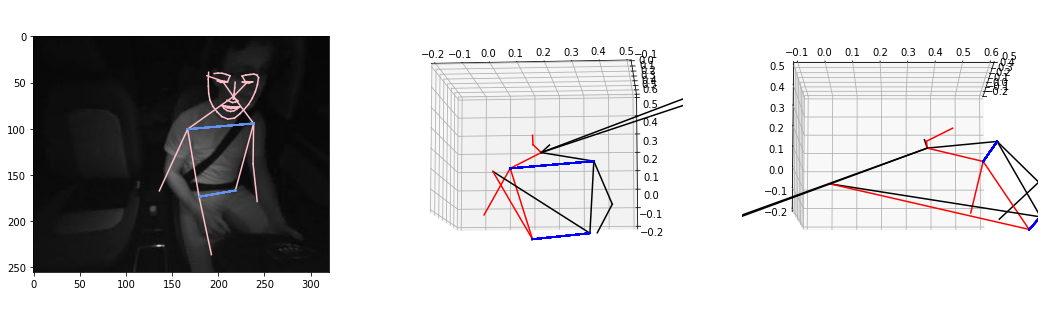

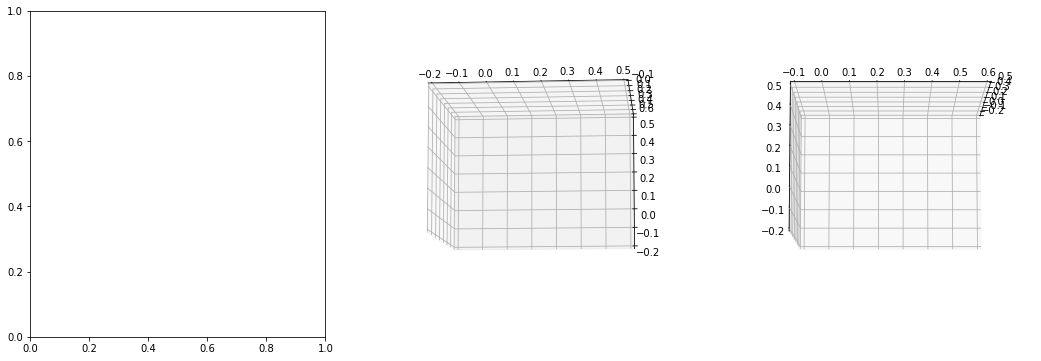

In [64]:
print(len(all_frames))

parents = FACE_AND_BODY_SKELETON.parents()
frame_id = 101
Kint = np.array([[567/4, 0, 640/4], [0, 567/4, 512/4], [0, 0, 1]])
for frame_id in range(10):
    fig = plt.figure( figsize=(18, 6))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.set_xlim3d([-0.2, 0.5])
    ax2.set_ylim3d([-0.1, 0.6])
    ax2.set_zlim3d([-0.2, 0.5])
    ax2.view_init(elev=-8, azim=-85)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.set_xlim3d([-0.2, 0.5])
    ax3.set_ylim3d([-0.1, 0.6])
    ax3.set_zlim3d([-0.2, 0.5])
    ax3.view_init(elev=-8, azim=0)
    plot_2d_skeleton(frame_id, keypoints, all_frames, parents, ax1)
    plot_3d_skeleton(frame_id, keypoints, keypoints3d, parents, FACE_AND_BODY_SKELETON, ax2)
    plot_3d_skeleton(frame_id, keypoints, keypoints3d, parents, FACE_AND_BODY_SKELETON, ax3)
    print(np.dot(Kint, keypoints3d[frame_id][6]) / keypoints3d[frame_id][6][2])
    print(np.dot(Kint, wkeypoints3d[frame_id][6]) / wkeypoints3d[frame_id][6][2])
    print(abs(np.min(keypoints3d[frame_id, 17:, 2])-np.max(keypoints3d[frame_id, 17:, 2]))) 
    print()

In [ ]:
from IPython import display

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()  